# Graph Community

### In this notebook, we perform the graph community detection using Louvain algorithm implementation in NetworkX package.

### Import libraries

In [1]:
%matplotlib inline

import os, sys, time
import pandas as pd, numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS, TSNE
import hdbscan
import pickle
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
from tqdm import tqdm
from natsort import natsorted

### Global variables

In [2]:
DATA = os.path.join('..', 'data')
RESULTS = os.path.join('..', 'results')

## Load the data

In [3]:
graph_df = pd.read_csv(os.path.join(RESULTS, 'graph-table.csv'))

print(f'Size of the data: {graph_df.shape}\n\n')
graph_df.head()

Size of the data: (16653, 3)




,parent,child,weight
0,Accompagnant éducatif et social,Accompagnateur,0.11
1,Accompagnant éducatif et social,Acheteur,0.05
2,Accompagnant éducatif et social,Administration des ventes,0.03
3,Accompagnant éducatif et social,Affrètement,0.05
4,Accompagnant éducatif et social,Agent d'entretien,0.07


### NetworkX graph

In [4]:
G = nx.from_pandas_edgelist(graph_df, source='parent', target='child', edge_attr='weight')
G.number_of_nodes()

183

In [5]:
# compute the best partition
partition = community_louvain.best_partition(graph=G, weight='weight',  resolution=0.7, randomize=None, random_state=42)

In [6]:
clusters_df = pd.DataFrame.from_dict(partition, orient='index', columns=['cluster'])
clusters_df = clusters_df.reset_index()
clusters_df.columns = ['profession', 'cluster']
clusters_df

,profession,cluster
0,Accompagnant éducatif et social,0
1,Accompagnateur,1
2,Acheteur,2
3,Administration des ventes,2
4,Affrètement,3
...,...,...
178,Tuyauteur,20
179,Téléprospecteur,2
180,Veilleur de nuit,29
181,Vendeur,9


In [7]:
print(f'Number of clusters: {len(list(set(clusters_df.cluster)))}')

Number of clusters: 36


In [8]:
print('Clusters sizes:\n')
clusters_df.cluster.value_counts()

Clusters sizes:



2     40
23    14
19    14
3     13
34     9
9      7
20     6
33     6
5      6
22     6
21     6
10     6
24     6
18     4
0      4
4      4
31     3
30     3
17     2
26     2
29     2
27     2
28     2
25     2
7      2
1      2
6      1
16     1
8      1
32     1
11     1
35     1
12     1
13     1
14     1
15     1
Name: cluster, dtype: int64

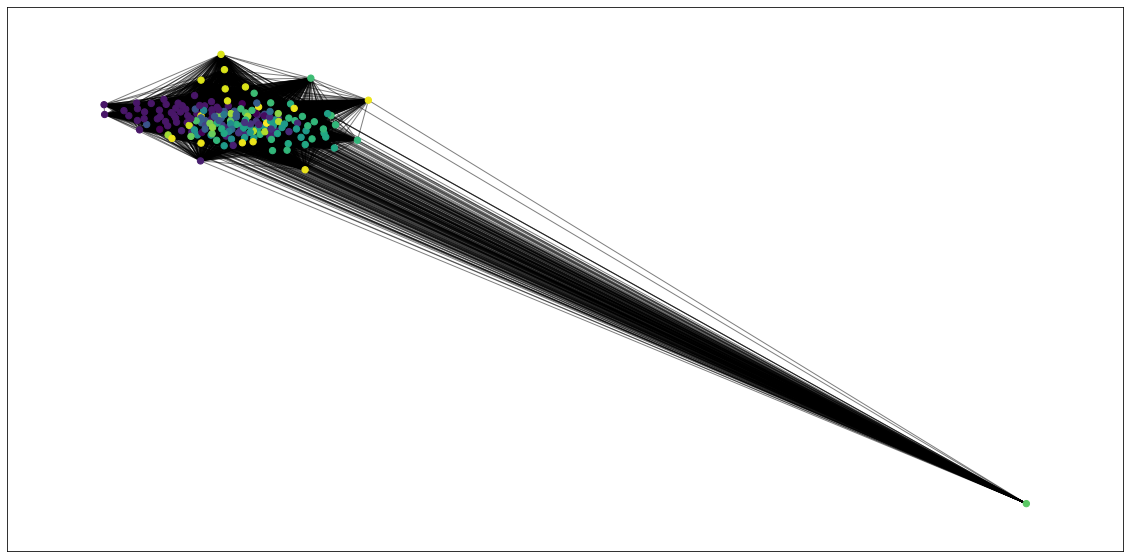

In [9]:
# draw the graph
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

#### Here, we could remove the apparent outlier point (on the left) before performing the clustering for a better visualization.

In [10]:
def get_clusters(df):
    """
    Get the professions associated to each cluster.
    
    Arguments:
        df: the dataframe with the clusters information.
    """
    
    clusters = sorted(list(set(df.cluster)))
    clusters_dic = {}
    
    for cluster in clusters:
        clust_df = df[df['cluster'] == cluster]
        clusters_dic[cluster] = natsorted(list(clust_df.profession))
        
    clusters_df = pd.DataFrame.from_dict(clusters_dic, orient='index')
    professions = []
    
    for idx in range(len(clusters_df)):
        professions.append(clusters_df.iloc[idx, :].tolist())
    professions = [[prof for prof in profs if prof] for profs in professions]
    
    clusters_df['professions'] = professions
    clusters_df = clusters_df['professions']
    clusters_df = clusters_df.reset_index()
    clusters_df.columns = ['cluster', 'professions']
    clusters_df['size'] = clusters_df['professions'].apply(lambda x: len(x))
    clusters_df = clusters_df.sort_values('size', ascending=False)
    clusters_df = clusters_df[clusters_df['size'] > 1]
    clusters_df = clusters_df.reset_index(drop=True)
    
    return clusters_df

In [11]:
df_clusters = get_clusters(clusters_df)
df_clusters.head(50)

,cluster,professions,size
0,2,"[Acheteur, Administration des ventes, Agent de...",40
1,19,"[Carreleur, Charpentier, Coffreur, Conducteur ...",14
2,23,"[Câbleur, Chef d'atelier, Chef d'équipe techni...",14
3,3,"[Affrètement, Agent d'exploitation, Agent de t...",13
4,34,"[Audit, Chercheur, Ingénieur, Manipulateur rad...",9
5,9,"[Animateur de ventes / Promotion, Artistique, ...",7
6,5,"[Agent de conditionnement, Carrossier, Manuten...",6
7,33,"[Infirmier, Infirmier anesthésiste, Infirmier ...",6
8,24,"[Auxiliaire puériculture, Directrice adjointe ...",6
9,10,"[Animation, Employé de caisse, Femme de chambr...",6


## Save the result

In [12]:
df_clusters.to_csv(os.path.join(RESULTS, 'graph-louvain-professions-per-cluster.csv'), index=False)